In [1]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os
import datetime

### Set seaborn style
sns.set(style="darkgrid")

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

#### Helper Functions
Below are a few helper functions that we will use extensively in our notebook. These have been moved to the top to prevent the flow of our analysis.

In [2]:
### Let us create a utility function to generate a list of null values in different dataframes
### We will utilize this function extensively througout the notebook. 
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

In [3]:
### let us create a reuseable function that will help us in ploting our barplots for analysis

def generateBarPlot(dataframe, keyVariable, plotSize):
    fig, axs = plt.subplots(figsize = plotSize)
    plt.xticks(rotation = 90)
    ax = sns.countplot(x=keyVariable, data=dataframe)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/len(dataframe) * 100),
                ha="center") 

In [4]:
### Let us define a reusable function to carry out Bivariate analysis as well.

def generateBiplot(df,col,title,figsize,hue=None):
    
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    plt.figure(figsize=figsize)
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,
                       palette='magma')
    
    convertcount=df.pivot_table(values='SalePrice',index=col,columns='SalePrice', aggfunc='count').fillna(0)
    convertcount["Conversion(%)"] =round(convertcount[1]/(convertcount[0]+convertcount[1]),2)*100
    return print(convertcount.sort_values(ascending=False,by="Conversion(%)"),plt.show())
        
    plt.show()

In [5]:
### Function to generate heatmaps

def generateHeatmaps(df, figsize):
    plt.figure(figsize = figsize)        # Size of the figure
    sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":7})


In [6]:
### Function to generate Boxplots
def generateBoxPlots(df, col, title, figsize):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=45)
    sns.boxplot(data =df, x=col,y='SalePrice')
    plt.title(title)
    plt.show()

In [7]:
### Function to generate Regplots

def generateRegPlots(df, col, title, figsize):
    plt.figure(figsize=figsize)

    sns.regplot(x=housingDataSet[col], y=housingDataSet.SalePrice)
    plt.ylabel('SalePrice', fontsize= 10)
    plt.xlabel('GrLivArea', fontsize= 10)
    plt.title(title, fontsize= 12)
    plt.show()

In [8]:
# writing a function to check if a particular category has high skeweness(i.e. one of the level is contributing to >=80%)
# we'll drop such columns

def dropSkewedColumns(col_name,data):
    try:
        
        print(f"The data shape is {data.shape}")
        null = round(100*(data[col_name].isnull().sum(axis=0)/len(data)),2)
        my_dict = (data[col_name].value_counts(normalize=True)*100).to_dict()
        print(data[col_name].value_counts(normalize=True)*100)
        logic = list(map(lambda x:x>=80, my_dict.values()))
        
        if logic.count(True)>0:
            print(f'The data is highly skewed, so we will be dropping the column {col_name} and null% is {null}')
            data.drop(col_name,axis=1,inplace=True)
            print(f'The shape of data after dropping {col_name} is {data.shape}')
        elif logic.count(True)==0:
            print(f'The data is not highly skewed, so we will not be dropping the column {col_name} and null% is {null}')
            
    except:
        print(f'The {col_name} doesnot exist in the data or it might have been dropped, please recheck')
            

In [9]:
### Function to generate ROC curves
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [10]:
### Let us create a reusable function to calculate VIF values for our models

def vifCalculator(inputModel):
    vif= pd.DataFrame()
    X = inputModel
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


### Importing Data & Checking 

In [11]:
housingDataSet = pd.read_csv("./train.csv")
housingDataSet.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Data Analysis and EDA
We will carry out some exploratory data analysis and understand the data better.

Steps taken:
-    Checking the shape, columns, datatypes etc. of the dataset
-    Assessing out of place values
-    Checking for duplicate values
-    Checking for null values
-    Dropping unnecessary columns
After this basic analysis we will carry out analysis of columns on individual basis and make a decision based on:

In [12]:
housingDataSet.shape

(1460, 81)

In [13]:
housingDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
housingDataSet.describe(percentiles=[0.15,0.35,0.55,0.75,0.95])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
15%,219.850000,20.000000,50.000000,6120.000000,5.000000,5.000000,1936.000000,1955.000000,0.000000,0.000000,0.000000,121.850000,701.700000,804.000000,0.000000,0.000000,988.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1953.000000,1.000000,272.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2006.000000,115000.000000
35%,511.650000,20.000000,60.000000,8450.000000,5.000000,5.000000,1961.000000,1976.000000,0.000000,56.650000,0.000000,320.650000,864.000000,959.650000,0.000000,0.000000,1262.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,6.000000,0.000000,1968.000000,2.000000,412.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,141000.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
55%,803.450000,60.000000,70.000000,9794.500000,6.000000,5.000000,1977.000000,1996.000000,0.000000,450.000000,0.000000,544.000000,1040.000000,1132.450000,0.000000,0.000000,1509.450000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,7.000000,1.000000,1988.000000,2.000000,490.000000,63.450000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,172500.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
95%,1387.050000,160.000000,107.000000,17401.1500

#### Observation

Based on our basic exploration we can say that:

- The shape of the dataset is 1460 columns & 81 rows
- There are a few outliers in this dataset in various numerical columns. For example: LotFrontage, LotArea etc. 
- We have 43 object type columns which we will treat as categorical columns. 
- we have 38 numerical columns.

In [15]:
### Checking for null values

generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
...,...,...
CentralAir,0,0.00
SaleCondition,0,0.00
Heating,0,0.00
TotalBsmtSF,0,0.00


### Observation

There are a lot of columns with high percentage of null values. From the data dictionary we know that these can be treated as missing features. We shall do some further analysis before we impute these with any values. 


Let us individually assess the categorical and continuous columns through univariate, bivariate and multivariate analysis methods.

### Categorical Columns

### MSZoning

In [16]:
housingDataSet.MSZoning.describe()

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

In [17]:
housingDataSet.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

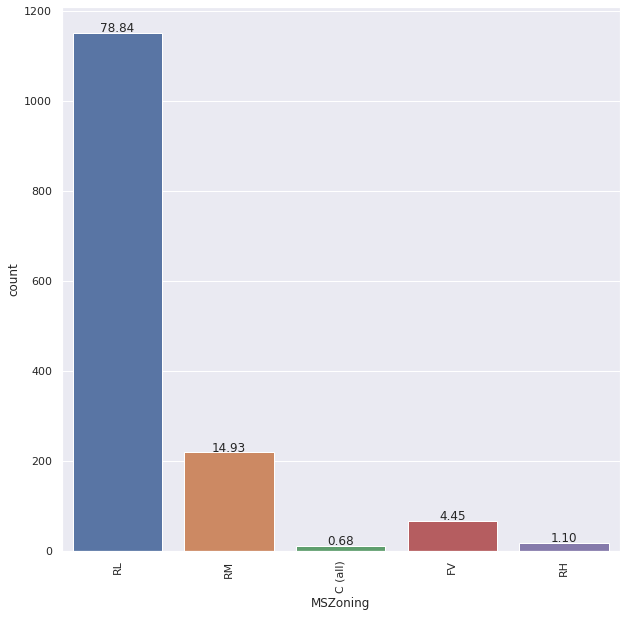

In [18]:
generateBarPlot(housingDataSet, 'MSZoning', (10,10))

### Observation

We can see from the barplot above that:

- 78.84% of the people live in the Residential Low Density zones
- Only 0.68% of the people live in Commercial zones
- We can consider binning the other categories as one because they form a fairly low percentage overall of the feature defined.

### Street

In [19]:
housingDataSet.Street.describe()

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

In [20]:
housingDataSet.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

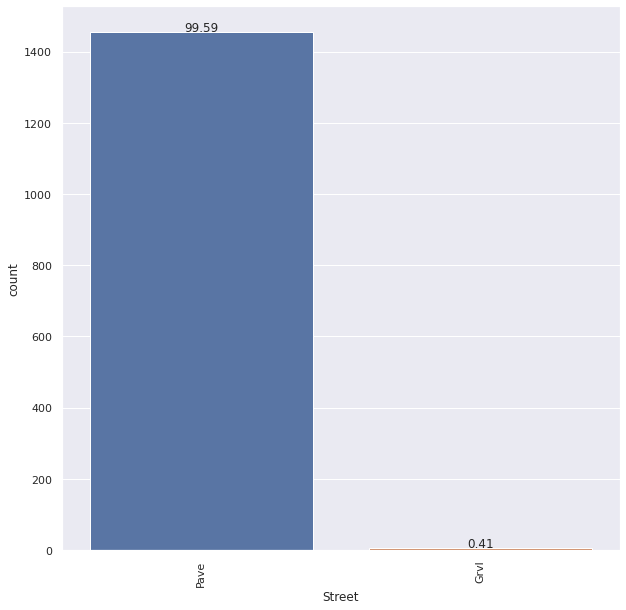

In [21]:
generateBarPlot(housingDataSet, 'Street', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed towards the 'Pave'.

We will drop this column as a highly skewed column has the tendency to skew results. 

We will assess all our columns first before we drop any.

### Alley

In [22]:
housingDataSet.Alley.describe()

count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

In [23]:
housingDataSet.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

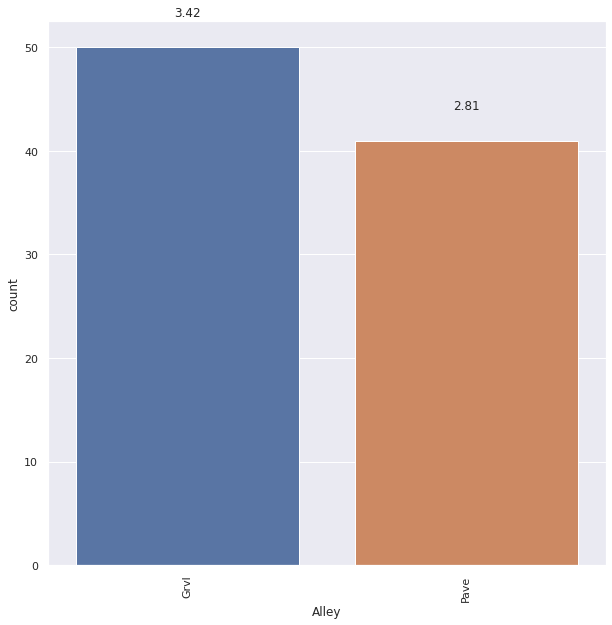

In [24]:
generateBarPlot(housingDataSet, 'Alley', (10,10))

### Observation

From the above barplot we can see that there is a discrepancy in the data. 

From our null value analysis we know that there is are over 90% null values in this column. 

We can therefore it is safe to consider dropping this variable.

### LotShape

In [25]:
housingDataSet.LotShape.describe()

count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

In [26]:
housingDataSet.LotShape.value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

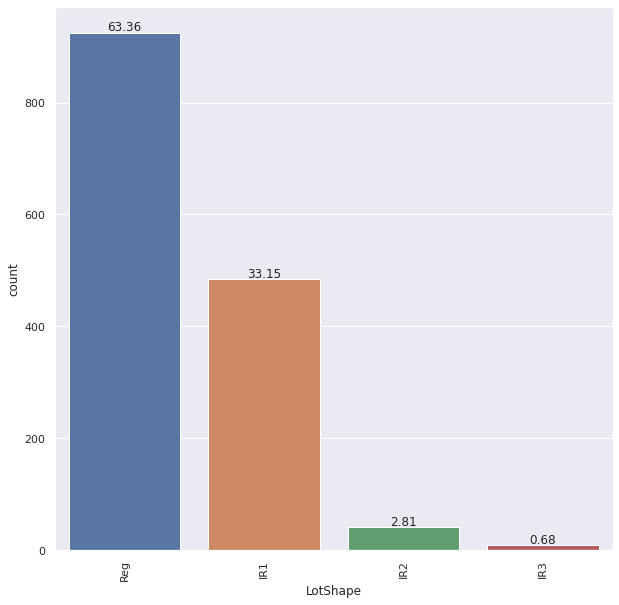

In [27]:
generateBarPlot(housingDataSet, 'LotShape', (10,10))

### Observation

From the barplot above we can see that:

- 63.36% of the people occupy regular shaped properties
- There are no null or missing values as the total of all the %values is 100


### LandContour

In [28]:
housingDataSet.LandContour.describe()

count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

In [29]:
housingDataSet.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

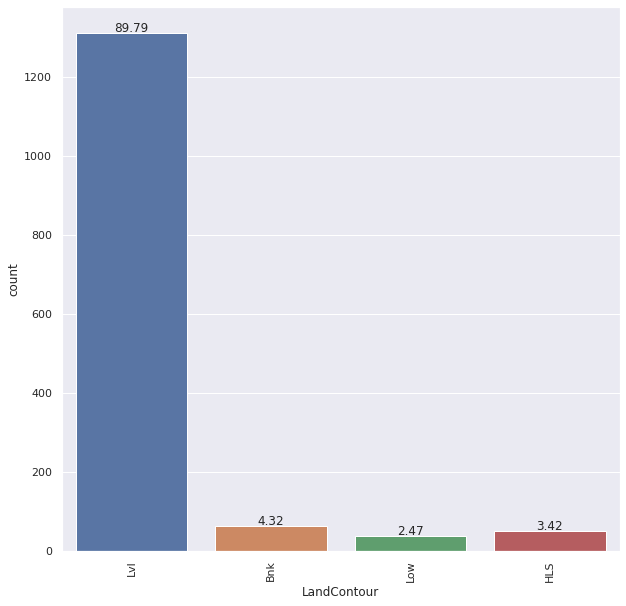

In [30]:
generateBarPlot(housingDataSet, 'LandContour', (10,10))

### Observation

From the barplot above we can see that the data is highly skewed in the Near Flat/Level section. It is safe to consider dropping this variable.

### Utilities

In [31]:
housingDataSet.Utilities.describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

In [32]:
housingDataSet.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

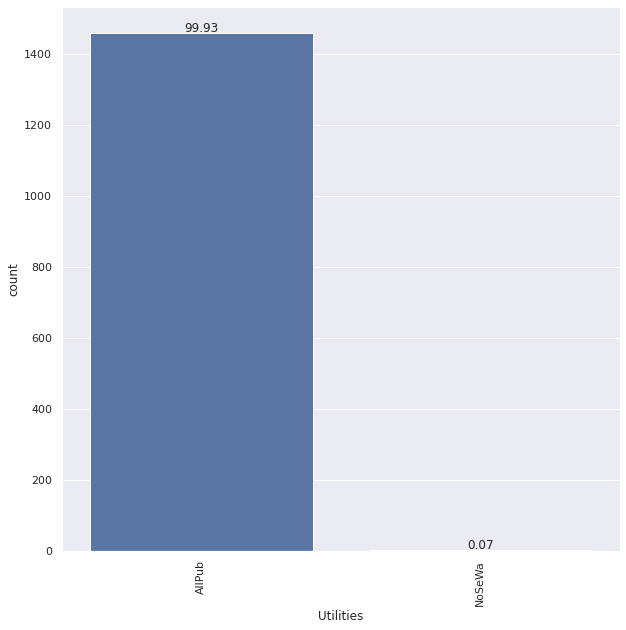

In [33]:
generateBarPlot(housingDataSet, 'Utilities', (10,10))

### Observation

From the barplot above we see that only 1 house does not have all the utilities available. This is again a highly skewed datapoint. It is safe to consider dropping this variable.

### LotConfig

In [34]:
housingDataSet.LotConfig.describe()

count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

In [35]:
housingDataSet.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

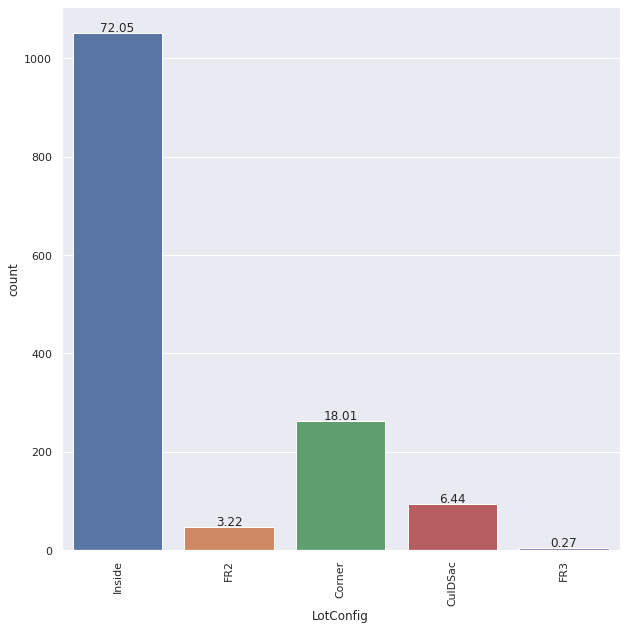

In [36]:
generateBarPlot(housingDataSet, 'LotConfig', (10,10))

### Observation

From the barplot above we can see that the data is slightly skewed, with 72% of it being an 'Inside Lot'

We can consider binning the categories with less than 10% of the data points together into a new category 'Others'

### LandSlope

In [37]:
housingDataSet.LandSlope.describe()

count     1460
unique       3
top        Gtl
freq      1382
Name: LandSlope, dtype: object

In [38]:
housingDataSet.LandSlope.value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

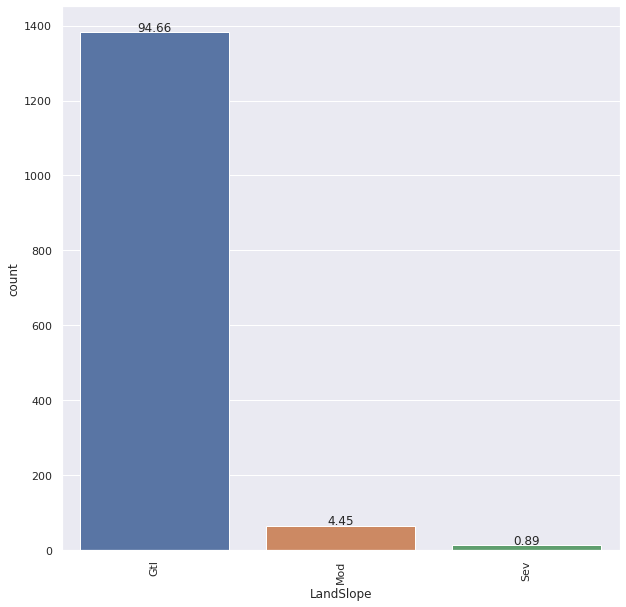

In [39]:
generateBarPlot(housingDataSet, 'LandSlope', (10,10))

### Observation

From the barplot above we can see that over 94% of the properties are on a Gentle Slope, with only 0.89% on a Severe slope. It is safe to consider dropping this variable since the data is so skewed.

### Neighborhood

In [40]:
housingDataSet.Neighborhood.describe()

count      1460
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

In [41]:
housingDataSet.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

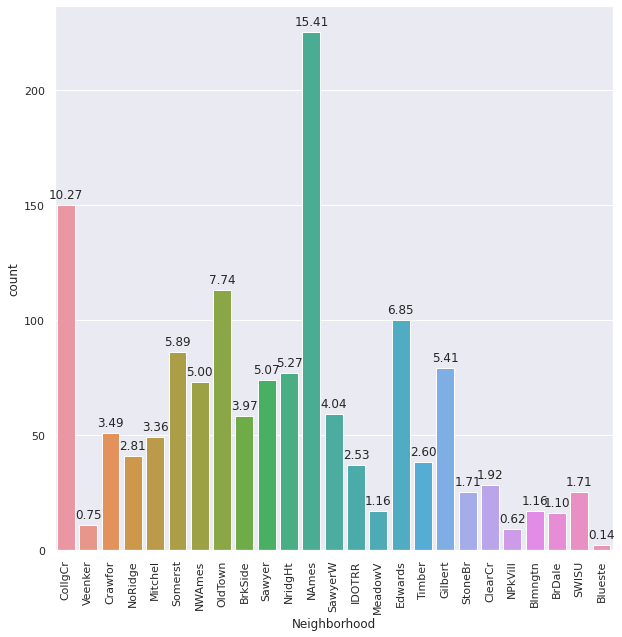

In [42]:
generateBarPlot(housingDataSet, 'Neighborhood', (10,10))

### Observation

From the barplot above we can see that:

- A lot of people prefer living in NAmes - North Ames in Sydney. 
- Only two people/families are living in Bluestem are.

It will be interesting to see the relationship this has with the sales pricing.

### HouseStyle

In [43]:
housingDataSet.HouseStyle.describe()

count       1460
unique         8
top       1Story
freq         726
Name: HouseStyle, dtype: object

In [44]:
housingDataSet.HouseStyle.value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

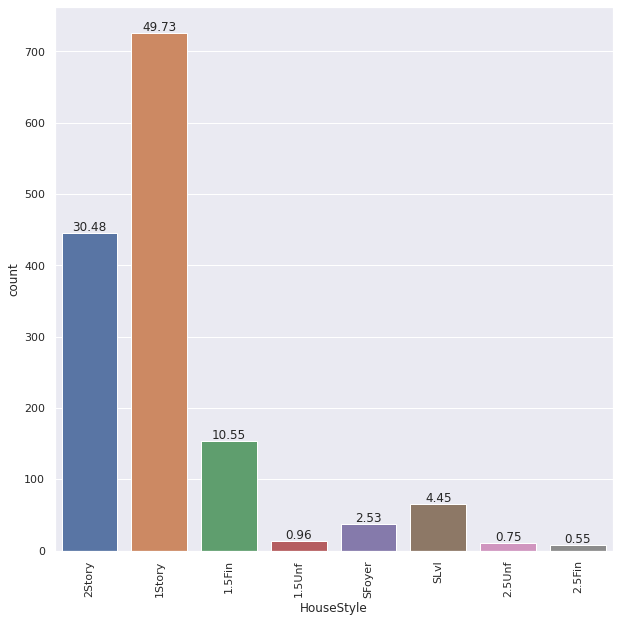

In [45]:
generateBarPlot(housingDataSet, 'HouseStyle', (10,10))

### Observation

From the above barplot we can see that:

- Most people prefer living in 1 story apartments
- Only a small number, 8, people/families prefer living in 2.5 story, furnished apartments.


### Continous Variables

In [46]:
housingDataSet.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


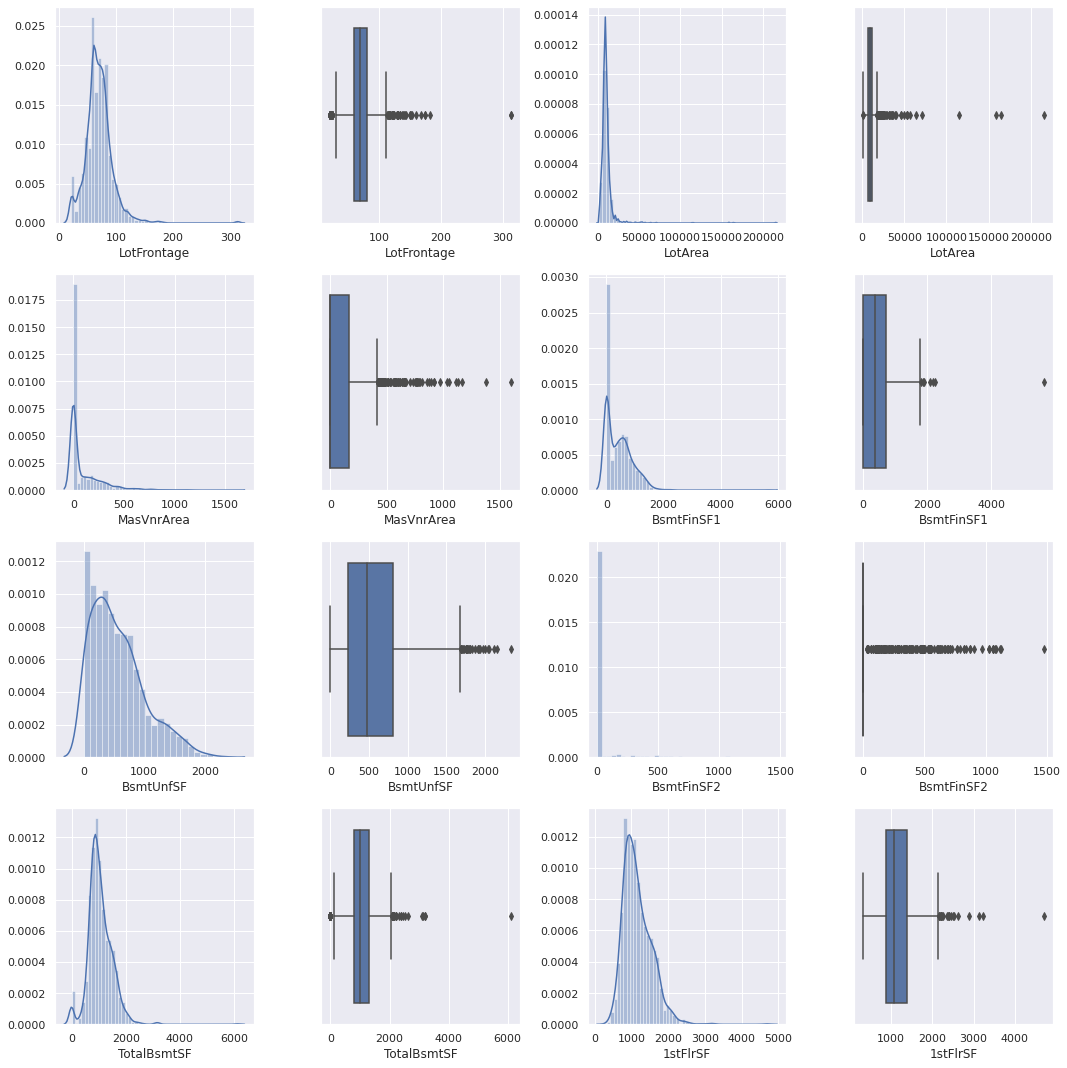

In [47]:
### We will not plot displots and barplot to assess all the numerical variables. We will be ignoring the ID feature.

fig, axs = plt.subplots(4,4, figsize = (15,15))


sns.distplot(housingDataSet['LotFrontage'], ax = axs[0,0])
sns.boxplot(housingDataSet['LotFrontage'], ax = axs[0,1])

plt3 = sns.distplot(housingDataSet['LotArea'], ax = axs[0,2])
plt4 = sns.boxplot(housingDataSet['LotArea'], ax = axs[0,3])

sns.distplot(housingDataSet['MasVnrArea'], ax = axs[1,0])
sns.boxplot(housingDataSet['MasVnrArea'], ax = axs[1,1])

sns.distplot(housingDataSet['BsmtFinSF1'], ax = axs[1,2])
sns.boxplot(housingDataSet['BsmtFinSF1'], ax = axs[1,3])

sns.distplot(housingDataSet['BsmtUnfSF'], ax = axs[2,0])
sns.boxplot(housingDataSet['BsmtUnfSF'], ax = axs[2,1])

## because of a library issue the below statements have been written slightly differently
sns.distplot(housingDataSet.BsmtFinSF2, ax= axs[2,2])
sns.boxplot(housingDataSet.BsmtFinSF2, ax= axs[2,3])

sns.distplot(housingDataSet['TotalBsmtSF'], ax = axs[3,0])
sns.boxplot(housingDataSet['TotalBsmtSF'], ax = axs[3,1])

sns.distplot(housingDataSet['1stFlrSF'], ax = axs[3,2])
sns.boxplot(housingDataSet['1stFlrSF'], ax = axs[3,3])


plt.tight_layout()

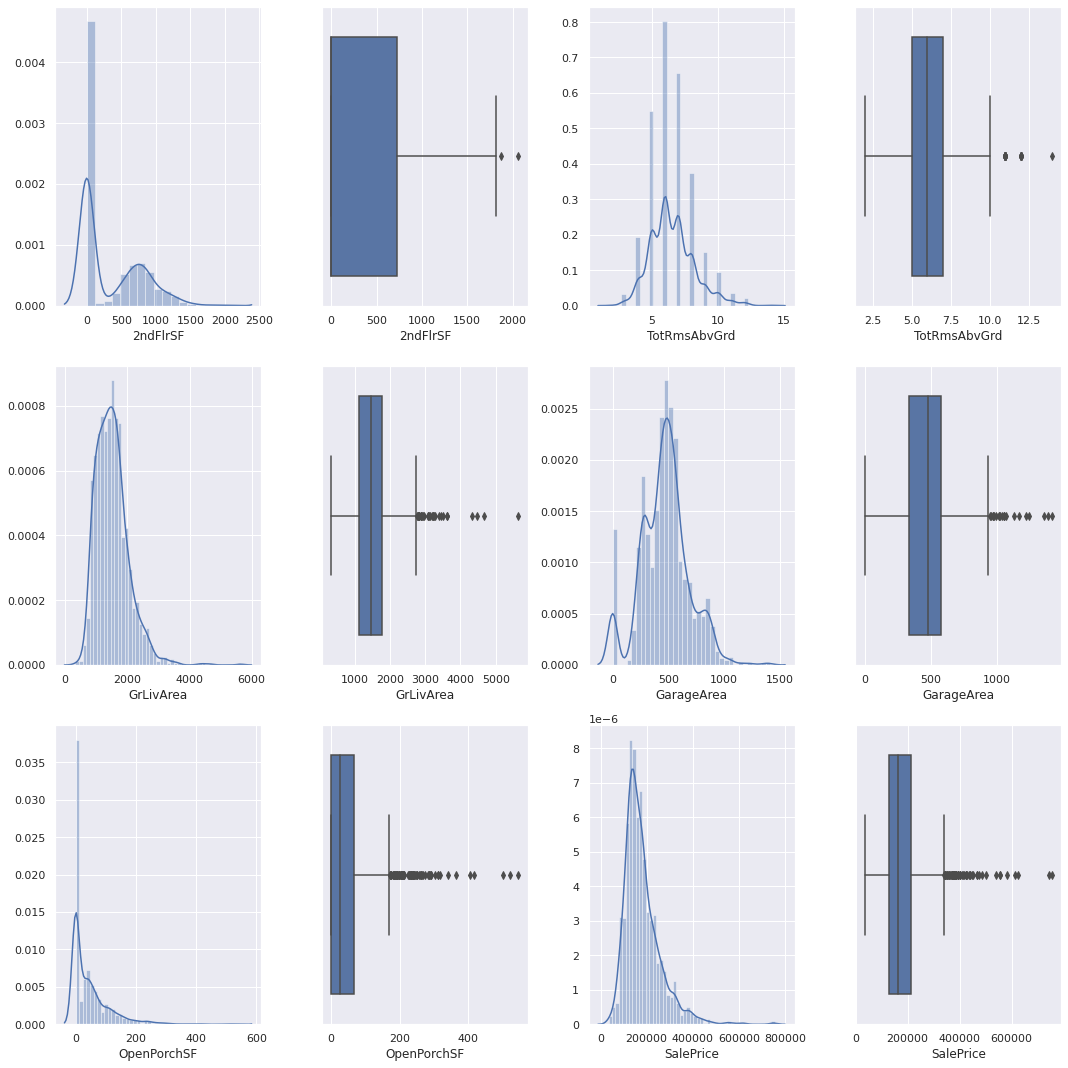

In [48]:
fig, axs = plt.subplots(3,4, figsize = (15,15))


plt1 = sns.distplot(housingDataSet['2ndFlrSF'], ax = axs[0,0])
plt2 = sns.boxplot(housingDataSet['2ndFlrSF'], ax = axs[0,1])

plt3 = sns.distplot(housingDataSet['TotRmsAbvGrd'], ax = axs[0,2])
plt4 = sns.boxplot(housingDataSet['TotRmsAbvGrd'], ax = axs[0,3])

plt5 = sns.distplot(housingDataSet['GrLivArea'], ax = axs[1,0])
plt6 = sns.boxplot(housingDataSet['GrLivArea'], ax = axs[1,1])

plt7 = sns.distplot(housingDataSet['GarageArea'], ax = axs[1,2])
plt8 = sns.boxplot(housingDataSet['GarageArea'], ax = axs[1,3])

plt9 = sns.distplot(housingDataSet['OpenPorchSF'], ax = axs[2,0])
plt10 = sns.boxplot(housingDataSet['OpenPorchSF'], ax = axs[2,1])

plt11 = sns.distplot(housingDataSet['SalePrice'], ax = axs[2,2])
plt12 = sns.boxplot(housingDataSet['SalePrice'], ax = axs[2,3])



plt.tight_layout()

### Observation

From the boxplots and displots for various variables we can observe:

- The target variable SalePrice is right skewed and has a few outlier present
- Most features seem to be right-skewed in nature with a few outliers present


We can cap the columns that have outliers and perform some outlier treatment on them. We will also try to transform the target variable so that we achieve a normal distribution.


## Bivatiate Analysis

To perform bivariate analysis we will take a subset of the numeric data columns from the original dataset.

In [49]:
### Creating new numeric dataset

housingDataSetNumericCols = housingDataSet.select_dtypes(include=['float64', 'int64'])
housingDataSetNumericCols.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [50]:
housingDataSetNumericCols.shape

(1460, 38)

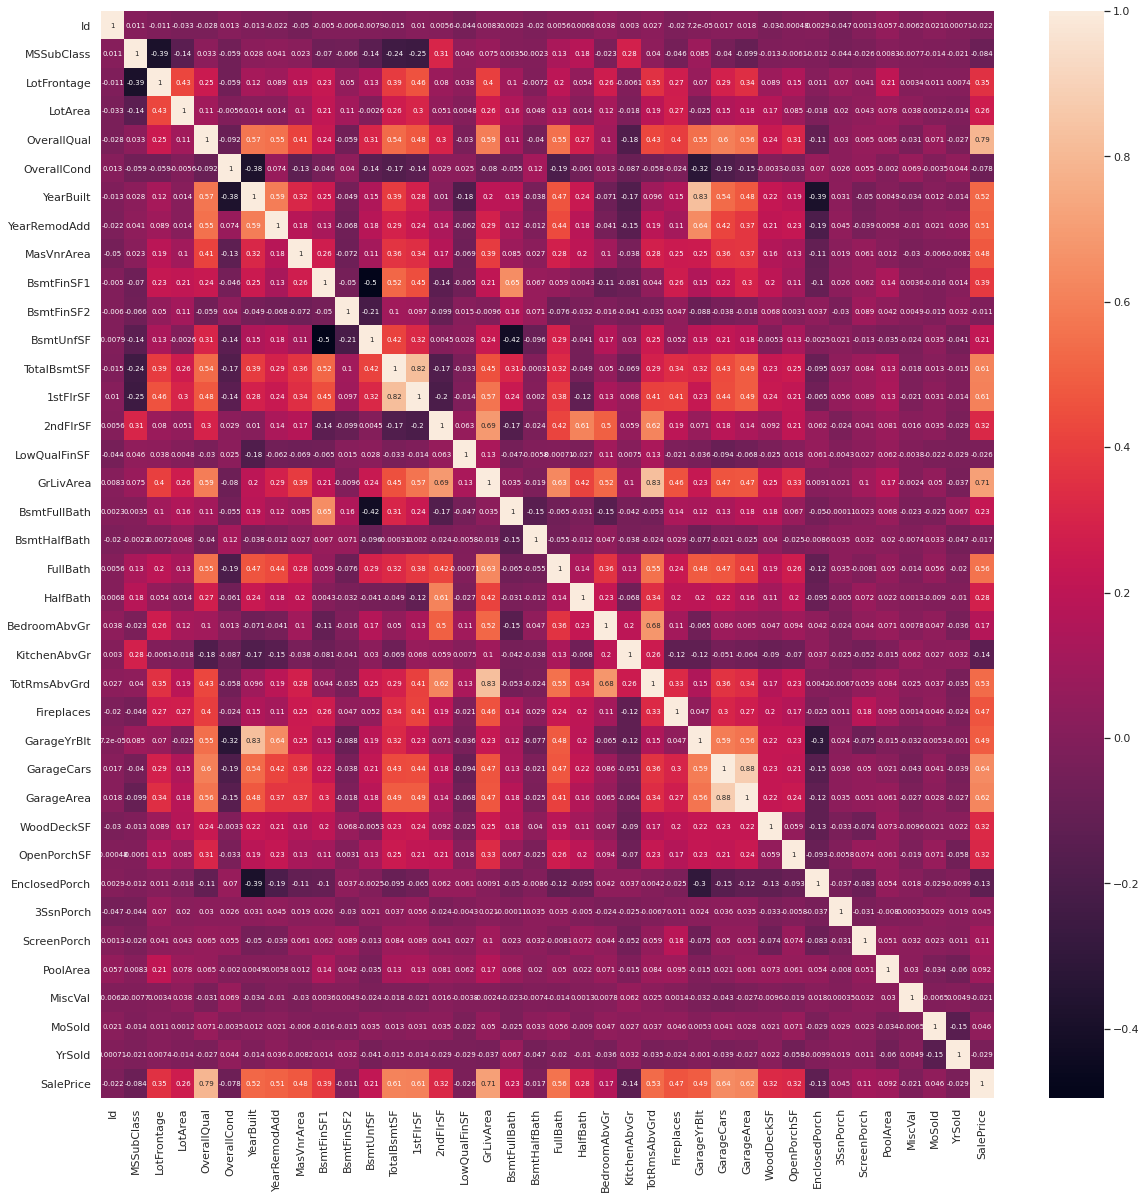

In [51]:
### Let us also generate a heatmap for the same
generateHeatmaps(housingDataSetNumericCols, (20,20))

### Observation

From the heatmap generated above we can see that some variables are strongly correlated with SalePrice.

- Specifically, these six features : OverallQual, GrlivArea, TotalBsmtSF, 1stFLrSF, GarageCars, and GrageArea. 

- There is also strong correlation between some variables, this suggests multicolinearity. There is a strong correlation between Yearbuilt and GarageYrBlt which means that most Garages are built in the same time with the construction of the houses. Therefeore,we can consider that Yearbuilt and GarageYrBlt as the same variable. 

- SalePrice is negatively correlated to KitchenAbvGr and EnclosedPorch

Let us plot a pairplot of some of the most correlated features with the SalePrice

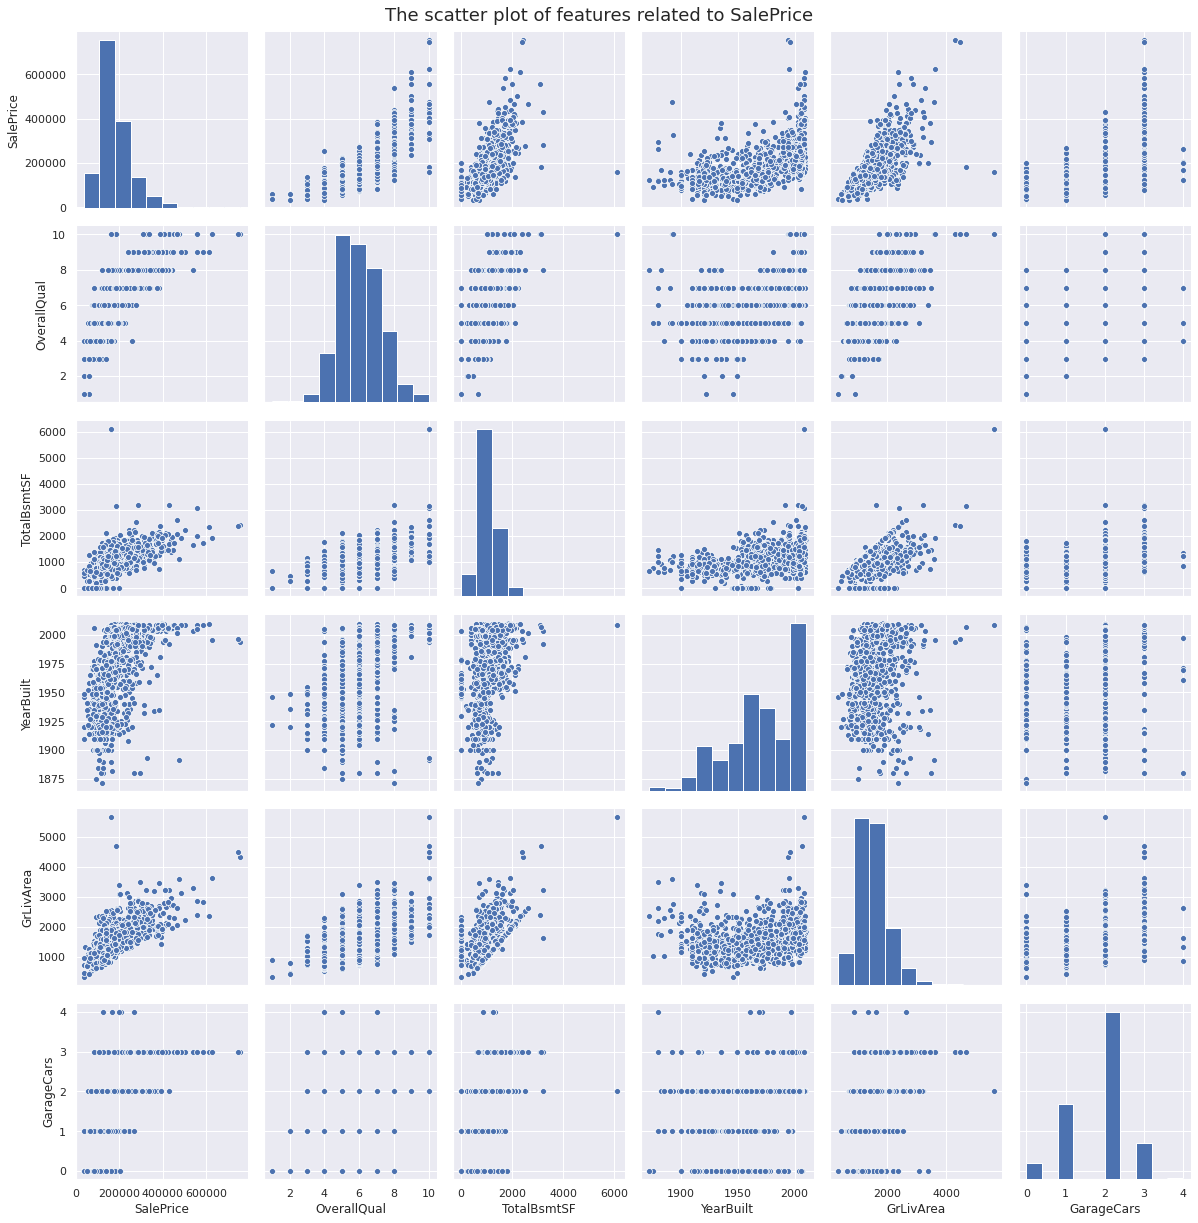

In [52]:
#Scatter plot of the most important features
corelatedCols = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'GrLivArea', 'GarageCars']
sns.pairplot(housingDataSetNumericCols[corelatedCols], size = 2.8)
plt.suptitle('The scatter plot of features related to SalePrice',x=0.5, y=1.01, verticalalignment='top', fontsize= 18)
plt.tight_layout()
plt.show()

### Observation

From the pairplot above we can see that there are a few outliers in the features TotalBamtSF & GrLivArea. Let us take a closer look ath them using a regplot.

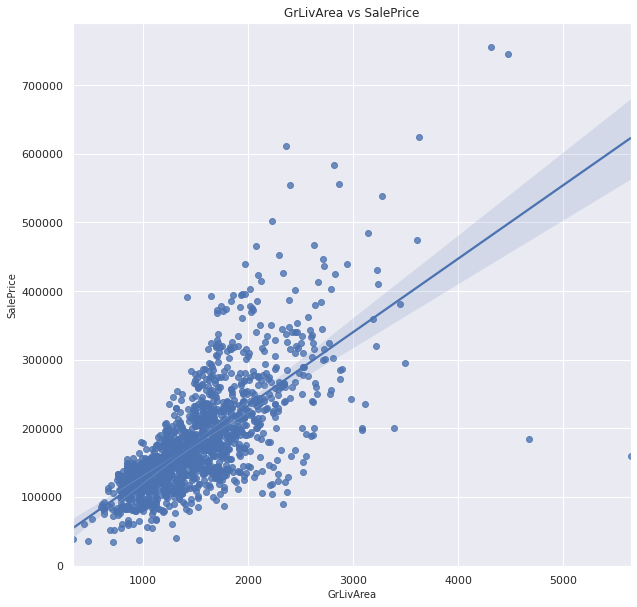

In [53]:
generateRegPlots(housingDataSet, 'GrLivArea', 'GrLivArea vs SalePrice', (10,10))

### Observation

From the above regplot we can see that there are 2 points that are Ground living area but have a very low SalePrice. they are clearly outliers and we will be removing them. 

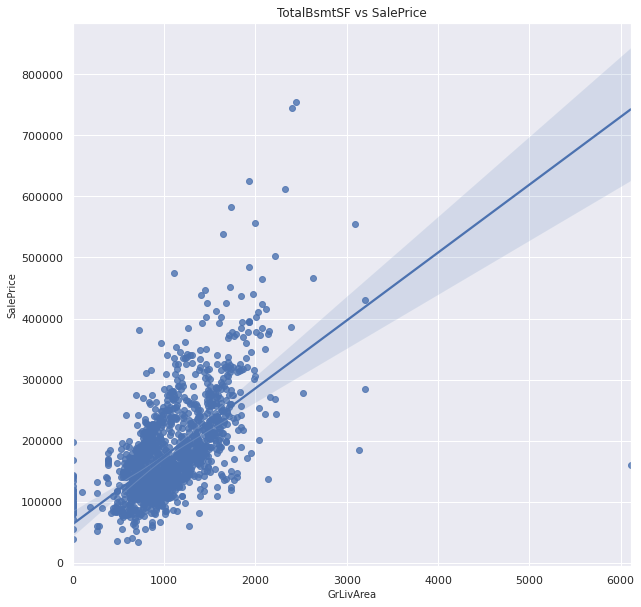

In [54]:
generateRegPlots(housingDataSet, 'TotalBsmtSF', 'TotalBsmtSF vs SalePrice', (10,10))

### Observation

There seems to be only one outlier, we can cap it if we choose. 

#### Plotting Continous - Categorical Variables

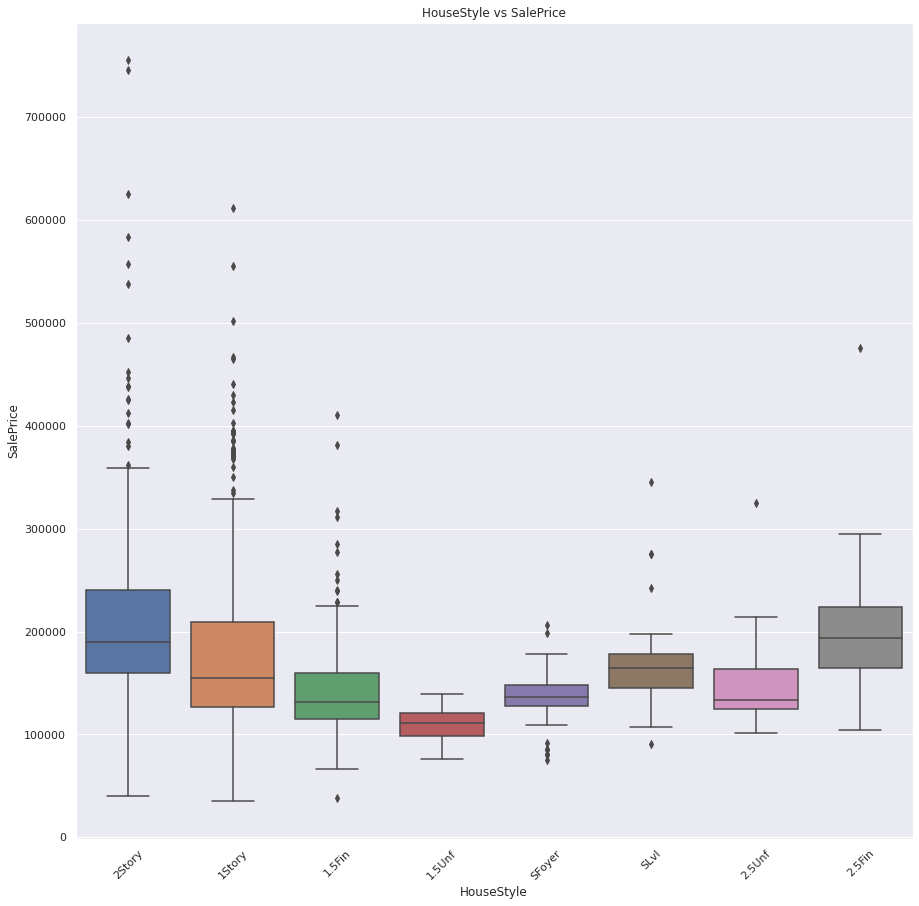

In [55]:
generateBoxPlots(housingDataSet, 'HouseStyle', 'HouseStyle vs SalePrice', (15,15))

### Observation

As we can see from the boxplot above"
- 2Story has the highlest range of SalePrice. They range from a very low SalePrice to a very high SalePrice
- Overall 1.5Unf has the lowest median prices of sale 

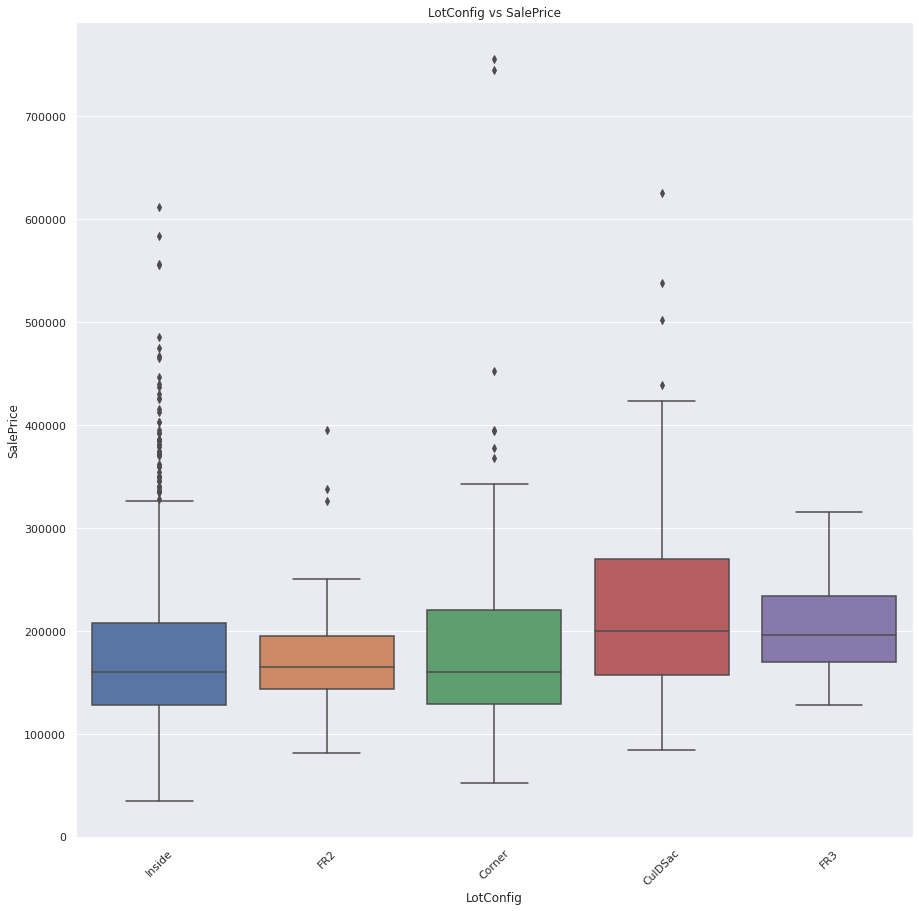

In [56]:
generateBoxPlots(housingDataSet, 'LotConfig','LotConfig vs SalePrice', (15,15))

### Observation

From the boxplot above we can say that:

- Properties with a Corner LotConfig have a few outliers
- Inside LotConfig Properties have a series of outliers that are relatively close to each other


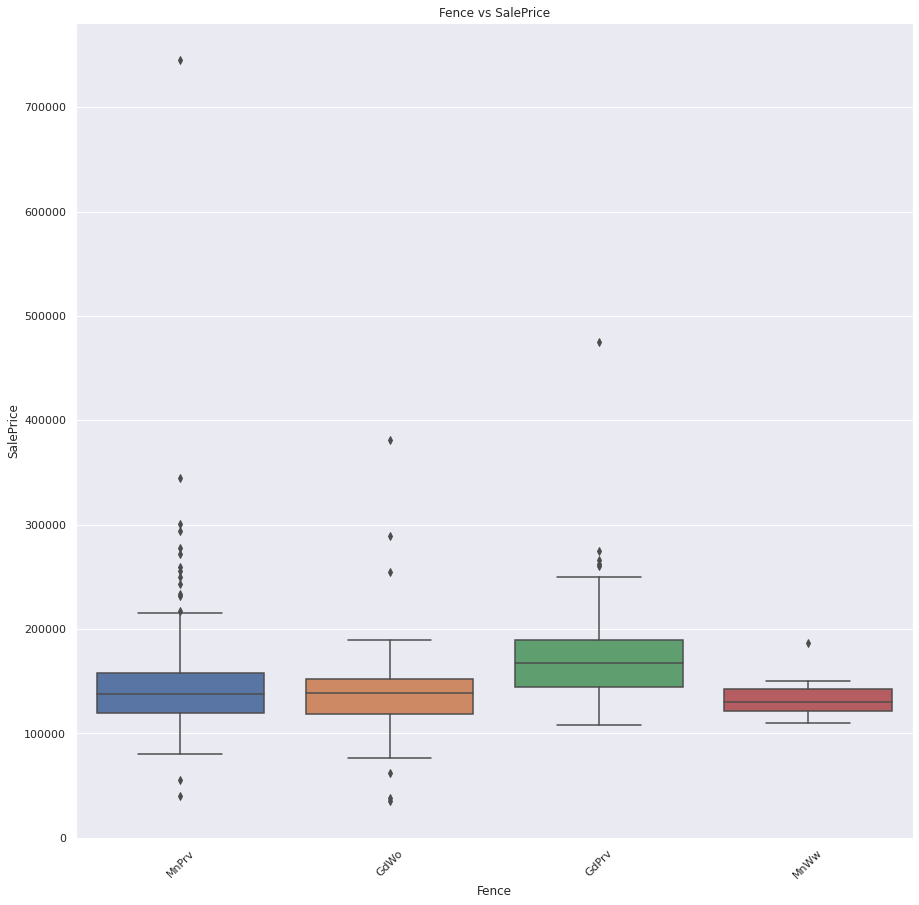

In [57]:
generateBoxPlots(housingDataSet, 'Fence','Fence vs SalePrice', (15,15))

### Observations

Fromt he boxplot above we can see that:

- Properties with Good Privacy have the best median sales price
- There are a few outliers in the properties that have minimum privacy as well
- The properties with Good Wooden fences and Minimum Privacy have relatively similar median prices

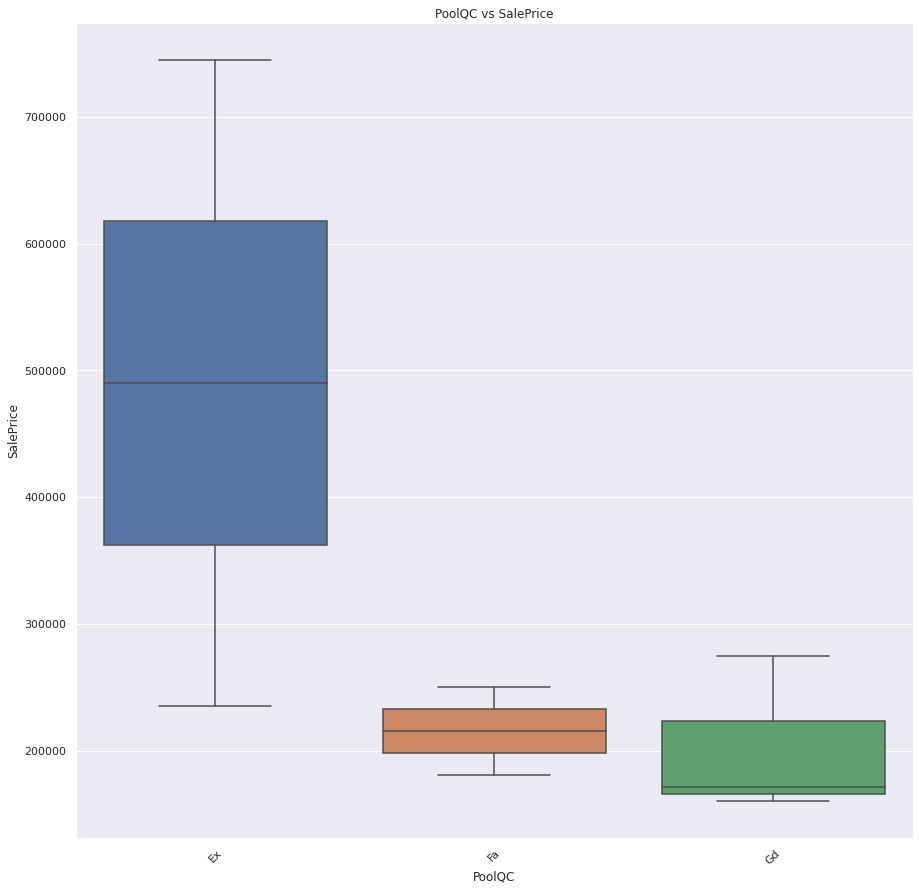

In [58]:
generateBoxPlots(housingDataSet, 'PoolQC','PoolQC vs SalePrice', (15,15))

### Observation

We can clearly see that properties with an Excellent pool quality go at the highest prices

### Note:

Now we will assess the columns with a high number of NaN values and impute them correctly:


In [59]:
### generate null values again
generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
...,...,...
CentralAir,0,0.00
SaleCondition,0,0.00
Heating,0,0.00
TotalBsmtSF,0,0.00


In [60]:
### Impute columns that have Nan values based on our understanding from the data dictionary with NO

#Alley
housingDataSet.Alley.fillna(inplace=True,value='No')
#BsmtQual
housingDataSet.BsmtQual.fillna(inplace=True,value='No')
#BsmtCond
housingDataSet.BsmtCond.fillna(inplace=True,value='No')
#BsmtExposure
housingDataSet.BsmtExposure.fillna(inplace=True,value='No')
#BsmtFinType1
housingDataSet.BsmtFinType1.fillna(inplace=True,value='No')
#BsmtFinType2
housingDataSet.BsmtFinType2.fillna(inplace=True,value='No')
#FireplaceQu
housingDataSet.FireplaceQu.fillna(inplace=True,value='No') 
#GarageType
housingDataSet.GarageType.fillna(inplace=True,value='No')
#GarageFinish
housingDataSet.GarageFinish.fillna(inplace=True,value='No')
#GarageQual 
housingDataSet.GarageQual.fillna(inplace=True,value='No')    
#GarageCond
housingDataSet.GarageCond.fillna(inplace=True,value='No')
#PoolQC
housingDataSet.PoolQC.fillna(inplace=True,value='No')    
#Fence
housingDataSet.Fence.fillna(inplace=True,value='No')
#MiscFeature
housingDataSet.MiscFeature.fillna(inplace=True,value='No')

### generate null values table again
generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrType,8,0.55
MasVnrArea,8,0.55
Electrical,1,0.07
...,...,...
TotRmsAbvGrd,0,0.00
Functional,0,0.00
Fireplaces,0,0.00
FireplaceQu,0,0.00


### Observation

As you can see, after we imputed the values with 'No' the columns with a high number of null values changed.

We will now check for row wise null values and consider dropping any rows that have a high number/more than 5% of null values in them.

In [61]:
housingDataSet.isnull().sum(axis=1).sort_values(ascending=False)

529     3
234     3
393     2
1030    2
977     2
       ..
897     0
898     0
899     0
901     0
0       0
Length: 1460, dtype: int64

### Observation

There arent a lot of rows with a high number of null values. So no rows will be dropped. 

We will now deal with the null values in the data set.

We will impute the null values of the Categorical columns with the Mode value and for the Continuous columns with the median or mean values. 

In [62]:
### Replacing na with Median value in LotFrontage column

housingDataSet.LotFrontage = housingDataSet.LotFrontage.fillna(housingDataSet.LotFrontage.median())

In [63]:
### Imputing values for MasVnrArea
housingDataSet.MasVnrArea = housingDataSet.MasVnrArea.fillna(housingDataSet.MasVnrArea.median())

In [64]:
generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
GarageYrBlt,81,5.55
MasVnrType,8,0.55
Electrical,1,0.07
SalePrice,0,0.00
ExterCond,0,0.00
...,...,...
TotRmsAbvGrd,0,0.00
Functional,0,0.00
Fireplaces,0,0.00
FireplaceQu,0,0.00


### Observation

As you can see above, we have successfully imputed the Na values with the median values. 

In [65]:
### Imputing values for MasVnrType
housingDataSet.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [66]:
### We will impute these values with the mode value for MasVnrType
housingDataSet.MasVnrType = housingDataSet.MasVnrType.fillna('None')
housingDataSet.MasVnrType.value_counts(dropna=False)

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [67]:
### Imputing values for 'Electrical'
housingDataSet.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [68]:
housingDataSet.Electrical = housingDataSet.Electrical.fillna('SBrkr')
housingDataSet.Electrical.value_counts(dropna=False)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [69]:
### Imputing values for GarageYrBlt. Since this is a numerical column we will convert it to object tyoe first

housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.astype('object')
housingDataSet.GarageYrBlt.value_counts(dropna=False)

NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1933.0     1
1927.0     1
1908.0     1
1906.0     1
1900.0     1
Name: GarageYrBlt, Length: 98, dtype: int64

In [70]:
housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.fillna(2005.0)
housingDataSet.GarageYrBlt.value_counts(dropna=False)

2005.0    146
2006.0     59
2004.0     53
2003.0     50
2007.0     49
         ... 
1908.0      1
1927.0      1
1933.0      1
1900.0      1
1906.0      1
Name: GarageYrBlt, Length: 97, dtype: int64

In [71]:
generateNullValuesPercentageTable(housingDataSet)

,Total Null Values,Percentage of Null Values
SalePrice,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
...,...,...
TotRmsAbvGrd,0,0.0
Functional,0,0.0
Fireplaces,0,0.0
FireplaceQu,0,0.0


### Observation

From the above we can see that there are no more null values present.

We will now convert some numerical columns into categorical columns.

In [72]:
housingDataSet['MSSubClass'] =  housingDataSet['MSSubClass'].astype('object')
housingDataSet['OverallQual'] =  housingDataSet['OverallQual'].astype('object')
housingDataSet['OverallCond'] =  housingDataSet['OverallCond'].astype('object')
housingDataSet['BsmtFullBath'] =  housingDataSet['BsmtFullBath'].astype('object')
housingDataSet['BsmtHalfBath'] =  housingDataSet['BsmtHalfBath'].astype('object')
housingDataSet['FullBath'] =  housingDataSet['FullBath'].astype('object')
housingDataSet['HalfBath'] =  housingDataSet['HalfBath'].astype('object')
housingDataSet['BedroomAbvGr'] =  housingDataSet['BedroomAbvGr'].astype('object')
housingDataSet['KitchenAbvGr'] =  housingDataSet['KitchenAbvGr'].astype('object')
housingDataSet['TotRmsAbvGrd'] =  housingDataSet['TotRmsAbvGrd'].astype('object')
housingDataSet['Fireplaces'] =  housingDataSet['Fireplaces'].astype('object')
housingDataSet['GarageCars'] =  housingDataSet['GarageCars'].astype('object')

In [73]:
# Let's just convert the categorical 'GarageYrBlt' back to continuous variable so that age calculation can be done on it

housingDataSet.GarageYrBlt = housingDataSet.GarageYrBlt.astype('float64')

In [74]:
# Creating some derived features 

now = datetime.datetime.now()

housingDataSet['Age_SinceConstruction'] = housingDataSet['YearBuilt'].apply(lambda x: now.year - x)
housingDataSet['Age_Remodel'] = housingDataSet['YearRemodAdd'].apply(lambda x: now.year - x)
housingDataSet['Age_Garage'] = housingDataSet['GarageYrBlt'].apply(lambda x: now.year - x)
housingDataSet['Age_SinceSold'] = housingDataSet['YrSold'].apply(lambda x: now.year - x)


In [75]:
housingDataSet.shape

(1460, 85)

In [76]:
# dropping the redundant year columns now since we already have the derived features out of it. We will create a new dataframe for this

housingDataSetDroppedColumns = housingDataSet.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis=1)

In [77]:
housingDataSetDroppedColumns.shape

(1460, 81)

### Observation

We have sucessfully dropped all the columns

We will also drop the Id and MoSold columns as well. 

In [78]:
housingDataSetDroppedColumns = housingDataSetDroppedColumns.drop(['MoSold','Id'],axis=1)

housingDataSetDroppedColumns.shape

(1460, 79)

### Observation

We have successfully dropped the redundant columns in the new dataframe. 

We will now drop any columns that have a highly skewed data pattern. For this we will use the dropSkewedCols function defined above and individually assess all the categorical columns.

In [79]:
housingDataSetDroppedColumns.select_dtypes(include=['object'])

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,3,1,Gd,8,Typ,0,No,Attchd,RFn,2,TA,TA,Y,No,No,No,WD,Normal
1,20,RL,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,No,No,No,WD,Normal
2,60,RL,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,No,No,No,WD,Normal
3,70,RL,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,TA,TA,Y,No,No,No,WD,Abnorml
4,60,RL,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,TA,TA,Y,No,No,No,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,No,No,No,WD,Normal
1456,20,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,Unf,2,TA,TA,Y,No,MnPrv,No,WD,Normal
1457,70,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,RFn,1,TA,TA,Y,No,GdPrv,Shed,WD,Normal
1458,20,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,1,0,1,0,2,1,Gd,5,Typ,0,No,Attchd,Unf,1,TA,TA,Y,No,No,No,WD,Normal


In [80]:
dropSkewedColumns('MSSubClass',housingDataSetDroppedColumns)

The data shape is (1460, 79)
20     36.712329
60     20.479452
50      9.863014
120     5.958904
30      4.726027
160     4.315068
70      4.109589
80      3.972603
90      3.561644
190     2.054795
85      1.369863
75      1.095890
45      0.821918
180     0.684932
40      0.273973
Name: MSSubClass, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSSubClass and null% is 0.0


In [81]:
dropSkewedColumns('MSZoning',housingDataSetDroppedColumns)

The data shape is (1460, 79)
RL         78.835616
RM         14.931507
FV          4.452055
RH          1.095890
C (all)     0.684932
Name: MSZoning, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSZoning and null% is 0.0


In [82]:
dropSkewedColumns('Street',housingDataSetDroppedColumns)

The data shape is (1460, 79)
Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64
The data is highly skewed, so we will be dropping the column Street and null% is 0.0
The shape of data after dropping Street is (1460, 78)


In [83]:
dropSkewedColumns('MSSubClass',housingDataSetDroppedColumns)

The data shape is (1460, 78)
20     36.712329
60     20.479452
50      9.863014
120     5.958904
30      4.726027
160     4.315068
70      4.109589
80      3.972603
90      3.561644
190     2.054795
85      1.369863
75      1.095890
45      0.821918
180     0.684932
40      0.273973
Name: MSSubClass, dtype: float64
The data is not highly skewed, so we will not be dropping the column MSSubClass and null% is 0.0


In [84]:
dropSkewedColumns('Alley',housingDataSetDroppedColumns)

The data shape is (1460, 78)
No      93.767123
Grvl     3.424658
Pave     2.808219
Name: Alley, dtype: float64
The data is highly skewed, so we will be dropping the column Alley and null% is 0.0
The shape of data after dropping Alley is (1460, 77)


In [85]:
dropSkewedColumns('LotShape',housingDataSetDroppedColumns)

The data shape is (1460, 77)
Reg    63.356164
IR1    33.150685
IR2     2.808219
IR3     0.684932
Name: LotShape, dtype: float64
The data is not highly skewed, so we will not be dropping the column LotShape and null% is 0.0


In [86]:
dropSkewedColumns('Utilities',housingDataSetDroppedColumns)

The data shape is (1460, 77)
AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64
The data is highly skewed, so we will be dropping the column Utilities and null% is 0.0
The shape of data after dropping Utilities is (1460, 76)


In [87]:
dropSkewedColumns('LandContour',housingDataSetDroppedColumns)

The data shape is (1460, 76)
Lvl    89.794521
Bnk     4.315068
HLS     3.424658
Low     2.465753
Name: LandContour, dtype: float64
The data is highly skewed, so we will be dropping the column LandContour and null% is 0.0
The shape of data after dropping LandContour is (1460, 75)


In [88]:
dropSkewedColumns('LotConfig',housingDataSetDroppedColumns)

The data shape is (1460, 75)
Inside     72.054795
Corner     18.013699
CulDSac     6.438356
FR2         3.219178
FR3         0.273973
Name: LotConfig, dtype: float64
The data is not highly skewed, so we will not be dropping the column LotConfig and null% is 0.0


In [89]:
dropSkewedColumns('LandSlope',housingDataSetDroppedColumns)

The data shape is (1460, 75)
Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64
The data is highly skewed, so we will be dropping the column LandSlope and null% is 0.0
The shape of data after dropping LandSlope is (1460, 74)


In [90]:
dropSkewedColumns('Neighborhood',housingDataSetDroppedColumns)

The data shape is (1460, 74)
NAmes      15.410959
CollgCr    10.273973
OldTown     7.739726
Edwards     6.849315
Somerst     5.890411
Gilbert     5.410959
NridgHt     5.273973
Sawyer      5.068493
NWAmes      5.000000
SawyerW     4.041096
BrkSide     3.972603
Crawfor     3.493151
Mitchel     3.356164
NoRidge     2.808219
Timber      2.602740
IDOTRR      2.534247
ClearCr     1.917808
SWISU       1.712329
StoneBr     1.712329
Blmngtn     1.164384
MeadowV     1.164384
BrDale      1.095890
Veenker     0.753425
NPkVill     0.616438
Blueste     0.136986
Name: Neighborhood, dtype: float64
The data is not highly skewed, so we will not be dropping the column Neighborhood and null% is 0.0


In [91]:
dropSkewedColumns('Condition1',housingDataSetDroppedColumns)

The data shape is (1460, 74)
Norm      86.301370
Feedr      5.547945
Artery     3.287671
RRAn       1.780822
PosN       1.301370
RRAe       0.753425
PosA       0.547945
RRNn       0.342466
RRNe       0.136986
Name: Condition1, dtype: float64
The data is highly skewed, so we will be dropping the column Condition1 and null% is 0.0
The shape of data after dropping Condition1 is (1460, 73)


In [92]:
dropSkewedColumns('Condition2',housingDataSetDroppedColumns)

The data shape is (1460, 73)
Norm      98.972603
Feedr      0.410959
Artery     0.136986
RRNn       0.136986
PosN       0.136986
PosA       0.068493
RRAe       0.068493
RRAn       0.068493
Name: Condition2, dtype: float64
The data is highly skewed, so we will be dropping the column Condition2 and null% is 0.0
The shape of data after dropping Condition2 is (1460, 72)


In [93]:
dropSkewedColumns('BldgType',housingDataSetDroppedColumns)

The data shape is (1460, 72)
1Fam      83.561644
TwnhsE     7.808219
Duplex     3.561644
Twnhs      2.945205
2fmCon     2.123288
Name: BldgType, dtype: float64
The data is highly skewed, so we will be dropping the column BldgType and null% is 0.0
The shape of data after dropping BldgType is (1460, 71)


In [94]:
dropSkewedColumns('HouseStyle',housingDataSetDroppedColumns)

The data shape is (1460, 71)
1Story    49.726027
2Story    30.479452
1.5Fin    10.547945
SLvl       4.452055
SFoyer     2.534247
1.5Unf     0.958904
2.5Unf     0.753425
2.5Fin     0.547945
Name: HouseStyle, dtype: float64
The data is not highly skewed, so we will not be dropping the column HouseStyle and null% is 0.0


In [95]:
dropSkewedColumns('OverallQual',housingDataSetDroppedColumns)

The data shape is (1460, 71)
5     27.191781
6     25.616438
7     21.849315
8     11.506849
4      7.945205
9      2.945205
3      1.369863
10     1.232877
2      0.205479
1      0.136986
Name: OverallQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column OverallQual and null% is 0.0


In [96]:
dropSkewedColumns('OverallCond',housingDataSetDroppedColumns)

The data shape is (1460, 71)
5    56.232877
6    17.260274
7    14.041096
8     4.931507
4     3.904110
3     1.712329
9     1.506849
2     0.342466
1     0.068493
Name: OverallCond, dtype: float64
The data is not highly skewed, so we will not be dropping the column OverallCond and null% is 0.0


In [97]:
dropSkewedColumns('RoofStyle',housingDataSetDroppedColumns)

The data shape is (1460, 71)
Gable      78.150685
Hip        19.589041
Flat        0.890411
Gambrel     0.753425
Mansard     0.479452
Shed        0.136986
Name: RoofStyle, dtype: float64
The data is not highly skewed, so we will not be dropping the column RoofStyle and null% is 0.0


In [98]:
dropSkewedColumns('RoofMatl',housingDataSetDroppedColumns)

The data shape is (1460, 71)
CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
ClyTile     0.068493
Roll        0.068493
Metal       0.068493
Membran     0.068493
Name: RoofMatl, dtype: float64
The data is highly skewed, so we will be dropping the column RoofMatl and null% is 0.0
The shape of data after dropping RoofMatl is (1460, 70)


In [99]:
dropSkewedColumns('Exterior1st',housingDataSetDroppedColumns)

The data shape is (1460, 70)
VinylSd    35.273973
HdBoard    15.205479
MetalSd    15.068493
Wd Sdng    14.109589
Plywood     7.397260
CemntBd     4.178082
BrkFace     3.424658
WdShing     1.780822
Stucco      1.712329
AsbShng     1.369863
BrkComm     0.136986
Stone       0.136986
AsphShn     0.068493
CBlock      0.068493
ImStucc     0.068493
Name: Exterior1st, dtype: float64
The data is not highly skewed, so we will not be dropping the column Exterior1st and null% is 0.0


In [100]:
dropSkewedColumns('Exterior2nd',housingDataSetDroppedColumns)

The data shape is (1460, 70)
VinylSd    34.520548
MetalSd    14.657534
HdBoard    14.178082
Wd Sdng    13.493151
Plywood     9.726027
CmentBd     4.109589
Wd Shng     2.602740
Stucco      1.780822
BrkFace     1.712329
AsbShng     1.369863
ImStucc     0.684932
Brk Cmn     0.479452
Stone       0.342466
AsphShn     0.205479
CBlock      0.068493
Other       0.068493
Name: Exterior2nd, dtype: float64
The data is not highly skewed, so we will not be dropping the column Exterior2nd and null% is 0.0


In [101]:
dropSkewedColumns('MasVnrType',housingDataSetDroppedColumns)

The data shape is (1460, 70)
None       59.726027
BrkFace    30.479452
Stone       8.767123
BrkCmn      1.027397
Name: MasVnrType, dtype: float64
The data is not highly skewed, so we will not be dropping the column MasVnrType and null% is 0.0


In [102]:
dropSkewedColumns('ExterQual',housingDataSetDroppedColumns)

The data shape is (1460, 70)
TA    62.054795
Gd    33.424658
Ex     3.561644
Fa     0.958904
Name: ExterQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column ExterQual and null% is 0.0


In [103]:
dropSkewedColumns('ExterCond',housingDataSetDroppedColumns)

The data shape is (1460, 70)
TA    87.808219
Gd    10.000000
Fa     1.917808
Ex     0.205479
Po     0.068493
Name: ExterCond, dtype: float64
The data is highly skewed, so we will be dropping the column ExterCond and null% is 0.0
The shape of data after dropping ExterCond is (1460, 69)


In [104]:
dropSkewedColumns('Foundation',housingDataSetDroppedColumns)

The data shape is (1460, 69)
PConc     44.315068
CBlock    43.424658
BrkTil    10.000000
Slab       1.643836
Stone      0.410959
Wood       0.205479
Name: Foundation, dtype: float64
The data is not highly skewed, so we will not be dropping the column Foundation and null% is 0.0


In [105]:
dropSkewedColumns('BsmtQual',housingDataSetDroppedColumns)

The data shape is (1460, 69)
TA    44.452055
Gd    42.328767
Ex     8.287671
No     2.534247
Fa     2.397260
Name: BsmtQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtQual and null% is 0.0


In [106]:
dropSkewedColumns('BsmtCond',housingDataSetDroppedColumns)

The data shape is (1460, 69)
TA    89.794521
Gd     4.452055
Fa     3.082192
No     2.534247
Po     0.136986
Name: BsmtCond, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtCond and null% is 0.0
The shape of data after dropping BsmtCond is (1460, 68)


In [107]:
dropSkewedColumns('BsmtExposure',housingDataSetDroppedColumns)

The data shape is (1460, 68)
No    67.876712
Av    15.136986
Gd     9.178082
Mn     7.808219
Name: BsmtExposure, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtExposure and null% is 0.0


In [108]:
dropSkewedColumns('BsmtFinType1',housingDataSetDroppedColumns)

The data shape is (1460, 68)
Unf    29.452055
GLQ    28.630137
ALQ    15.068493
BLQ    10.136986
Rec     9.109589
LwQ     5.068493
No      2.534247
Name: BsmtFinType1, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtFinType1 and null% is 0.0


In [109]:
dropSkewedColumns('BsmtFinType2',housingDataSetDroppedColumns)

The data shape is (1460, 68)
Unf    86.027397
Rec     3.698630
LwQ     3.150685
No      2.602740
BLQ     2.260274
ALQ     1.301370
GLQ     0.958904
Name: BsmtFinType2, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtFinType2 and null% is 0.0
The shape of data after dropping BsmtFinType2 is (1460, 67)


In [110]:
dropSkewedColumns('BsmtFinType2',housingDataSetDroppedColumns)

The data shape is (1460, 67)
The BsmtFinType2 doesnot exist in the data or it might have been dropped, please recheck


In [111]:
dropSkewedColumns('Heating',housingDataSetDroppedColumns)

The data shape is (1460, 67)
GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64
The data is highly skewed, so we will be dropping the column Heating and null% is 0.0
The shape of data after dropping Heating is (1460, 66)


In [112]:
dropSkewedColumns('HeatingQC',housingDataSetDroppedColumns)

The data shape is (1460, 66)
Ex    50.753425
TA    29.315068
Gd    16.506849
Fa     3.356164
Po     0.068493
Name: HeatingQC, dtype: float64
The data is not highly skewed, so we will not be dropping the column HeatingQC and null% is 0.0


In [113]:
dropSkewedColumns('CentralAir',housingDataSetDroppedColumns)

The data shape is (1460, 66)
Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64
The data is highly skewed, so we will be dropping the column CentralAir and null% is 0.0
The shape of data after dropping CentralAir is (1460, 65)


In [114]:
dropSkewedColumns('Electrical',housingDataSetDroppedColumns)

The data shape is (1460, 65)
SBrkr    91.438356
FuseA     6.438356
FuseF     1.849315
FuseP     0.205479
Mix       0.068493
Name: Electrical, dtype: float64
The data is highly skewed, so we will be dropping the column Electrical and null% is 0.0
The shape of data after dropping Electrical is (1460, 64)


In [115]:
dropSkewedColumns('BsmtFullBath',housingDataSetDroppedColumns)

The data shape is (1460, 64)
0    58.630137
1    40.273973
2     1.027397
3     0.068493
Name: BsmtFullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column BsmtFullBath and null% is 0.0


In [116]:
dropSkewedColumns('BsmtHalfBath',housingDataSetDroppedColumns)

The data shape is (1460, 64)
0    94.383562
1     5.479452
2     0.136986
Name: BsmtHalfBath, dtype: float64
The data is highly skewed, so we will be dropping the column BsmtHalfBath and null% is 0.0
The shape of data after dropping BsmtHalfBath is (1460, 63)


In [117]:
dropSkewedColumns('FullBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
2    52.602740
1    44.520548
3     2.260274
0     0.616438
Name: FullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column FullBath and null% is 0.0


In [118]:
dropSkewedColumns('FullBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
2    52.602740
1    44.520548
3     2.260274
0     0.616438
Name: FullBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column FullBath and null% is 0.0


In [119]:
dropSkewedColumns('HalfBath',housingDataSetDroppedColumns)

The data shape is (1460, 63)
0    62.534247
1    36.643836
2     0.821918
Name: HalfBath, dtype: float64
The data is not highly skewed, so we will not be dropping the column HalfBath and null% is 0.0


In [120]:
dropSkewedColumns('BedroomAbvGr',housingDataSetDroppedColumns)

The data shape is (1460, 63)
3    55.068493
2    24.520548
4    14.589041
1     3.424658
5     1.438356
6     0.479452
0     0.410959
8     0.068493
Name: BedroomAbvGr, dtype: float64
The data is not highly skewed, so we will not be dropping the column BedroomAbvGr and null% is 0.0


In [121]:
dropSkewedColumns('KitchenAbvGr',housingDataSetDroppedColumns)

The data shape is (1460, 63)
1    95.342466
2     4.452055
3     0.136986
0     0.068493
Name: KitchenAbvGr, dtype: float64
The data is highly skewed, so we will be dropping the column KitchenAbvGr and null% is 0.0
The shape of data after dropping KitchenAbvGr is (1460, 62)


In [122]:
dropSkewedColumns('KitchenQual',housingDataSetDroppedColumns)

The data shape is (1460, 62)
TA    50.342466
Gd    40.136986
Ex     6.849315
Fa     2.671233
Name: KitchenQual, dtype: float64
The data is not highly skewed, so we will not be dropping the column KitchenQual and null% is 0.0


In [123]:
dropSkewedColumns('TotRmsAbvGrd',housingDataSetDroppedColumns)

The data shape is (1460, 62)
6     27.534247
7     22.534247
5     18.835616
8     12.808219
4      6.643836
9      5.136986
10     3.219178
11     1.232877
3      1.164384
12     0.753425
14     0.068493
2      0.068493
Name: TotRmsAbvGrd, dtype: float64
The data is not highly skewed, so we will not be dropping the column TotRmsAbvGrd and null% is 0.0


In [124]:
dropSkewedColumns('Functional',housingDataSetDroppedColumns)

The data shape is (1460, 62)
Typ     93.150685
Min2     2.328767
Min1     2.123288
Mod      1.027397
Maj1     0.958904
Maj2     0.342466
Sev      0.068493
Name: Functional, dtype: float64
The data is highly skewed, so we will be dropping the column Functional and null% is 0.0
The shape of data after dropping Functional is (1460, 61)


In [125]:
dropSkewedColumns('Fireplaces',housingDataSetDroppedColumns)

The data shape is (1460, 61)
0    47.260274
1    44.520548
2     7.876712
3     0.342466
Name: Fireplaces, dtype: float64
The data is not highly skewed, so we will not be dropping the column Fireplaces and null% is 0.0


In [126]:
dropSkewedColumns('FireplaceQu',housingDataSetDroppedColumns)

The data shape is (1460, 61)
No    47.260274
Gd    26.027397
TA    21.438356
Fa     2.260274
Ex     1.643836
Po     1.369863
Name: FireplaceQu, dtype: float64
The data is not highly skewed, so we will not be dropping the column FireplaceQu and null% is 0.0


In [127]:
dropSkewedColumns('GarageType',housingDataSetDroppedColumns)

The data shape is (1460, 61)
Attchd     59.589041
Detchd     26.506849
BuiltIn     6.027397
No          5.547945
Basment     1.301370
CarPort     0.616438
2Types      0.410959
Name: GarageType, dtype: float64
The data is not highly skewed, so we will not be dropping the column GarageType and null% is 0.0


In [128]:
dropSkewedColumns('GarageFinish',housingDataSetDroppedColumns)

The data shape is (1460, 61)
Unf    41.438356
RFn    28.904110
Fin    24.109589
No      5.547945
Name: GarageFinish, dtype: float64
The data is not highly skewed, so we will not be dropping the column GarageFinish and null% is 0.0


In [129]:
dropSkewedColumns('GarageQual',housingDataSetDroppedColumns)

The data shape is (1460, 61)
TA    89.794521
No     5.547945
Fa     3.287671
Gd     0.958904
Po     0.205479
Ex     0.205479
Name: GarageQual, dtype: float64
The data is highly skewed, so we will be dropping the column GarageQual and null% is 0.0
The shape of data after dropping GarageQual is (1460, 60)


In [130]:
dropSkewedColumns('GarageCond',housingDataSetDroppedColumns)

The data shape is (1460, 60)
TA    90.821918
No     5.547945
Fa     2.397260
Gd     0.616438
Po     0.479452
Ex     0.136986
Name: GarageCond, dtype: float64
The data is highly skewed, so we will be dropping the column GarageCond and null% is 0.0
The shape of data after dropping GarageCond is (1460, 59)


In [131]:
dropSkewedColumns('PoolQC',housingDataSetDroppedColumns)

The data shape is (1460, 59)
No    99.520548
Gd     0.205479
Fa     0.136986
Ex     0.136986
Name: PoolQC, dtype: float64
The data is highly skewed, so we will be dropping the column PoolQC and null% is 0.0
The shape of data after dropping PoolQC is (1460, 58)


In [132]:
dropSkewedColumns('Fence',housingDataSetDroppedColumns)

The data shape is (1460, 58)
No       80.753425
MnPrv    10.753425
GdPrv     4.041096
GdWo      3.698630
MnWw      0.753425
Name: Fence, dtype: float64
The data is highly skewed, so we will be dropping the column Fence and null% is 0.0
The shape of data after dropping Fence is (1460, 57)


In [133]:
dropSkewedColumns('SaleType',housingDataSetDroppedColumns)

The data shape is (1460, 57)
WD       86.780822
New       8.356164
COD       2.945205
ConLD     0.616438
ConLw     0.342466
ConLI     0.342466
CWD       0.273973
Oth       0.205479
Con       0.136986
Name: SaleType, dtype: float64
The data is highly skewed, so we will be dropping the column SaleType and null% is 0.0
The shape of data after dropping SaleType is (1460, 56)


In [134]:
dropSkewedColumns('SaleCondition',housingDataSetDroppedColumns)

The data shape is (1460, 56)
Normal     82.054795
Partial     8.561644
Abnorml     6.917808
Family      1.369863
Alloca      0.821918
AdjLand     0.273973
Name: SaleCondition, dtype: float64
The data is highly skewed, so we will be dropping the column SaleCondition and null% is 0.0
The shape of data after dropping SaleCondition is (1460, 55)


In [135]:
housingDataSetDroppedColumns.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,SalePrice,Age_SinceConstruction,Age_Remodel,Age_Garage,Age_SinceSold
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,2,1,3,Gd,8,0,No,Attchd,RFn,2,548,Y,0,61,0,0,0,0,No,0,208500,17,17,17.0,12
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,Y,298,0,0,0,0,0,No,0,181500,44,44,44.0,13
2,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,608,Y,0,42,0,0,0,0,No,0,223500,19,18,19.0,12
3,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,642,Y,0,35,272,0,0,0,No,0,140000,105,50,22.0,14
4,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,836,Y,192,84,0,0,0,0,No,0,250000,20,20,20.0,12


In [136]:
housingDataSetDroppedColumns.shape

(1460, 55)

In [137]:
housingDataSetDroppedColumns.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,Age_SinceConstruction,Age_Remodel,Age_Garage,Age_SinceSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,48.732192,35.134247,40.023973,12.184247
std,22.027677,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.202904,20.645407,24.749688,1.328095
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,10.000000,10.000000,10.000000,10.000000
25%,60.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,20.000000,16.000000,17.000000,11.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,47.000000,26.000000,35.500000,12.000000
75%,79.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,66.000000,53.000000,58.000000,13.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000,148.000000,70.000000,120.000000,14.000000
